# Tree-based Classification  
data : https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?select=data.csv

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Convert raw data to Datacamp sample format
df = \
(pd
 .read_csv('../dataset/breast.csv')
 .replace({'diagnosis':{'M':1, 'B':0}})
 .loc[:,['diagnosis','radius_mean', 'concave points_mean']]
)
y = df['diagnosis'].to_numpy()
X = df[['radius_mean', 'concave points_mean']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=1)

In [3]:
dt = DecisionTreeClassifier(max_depth=6, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(y_pred[:5])

[0 0 0 1 0]


In [4]:
# Accuracy score could use internal function or sklearn metrics
print(dt.score(X_test, y_test)); print(accuracy_score(y_test, y_pred))

0.8859649122807017
0.8859649122807017


In [7]:
def plot_decision_regions(X, y, clf,
                          feature_index=None,
                          filler_feature_values=None,
                          filler_feature_ranges=None,
                          ax=None,
                          X_highlight=None,
                          res=0.02, legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors='red,blue,limegreen,gray,cyan'):
    """Plot decision regions of a classifier.

    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.
    y : array-like, shape = [n_samples]
        True class labels.
    clf : Classifier object.
        Must have a .predict method.
    feature_index : array-like (default: (0,) for 1D, (0, 1) otherwise)
        Feature indices to use for plotting. The first index in
        `feature_index` will be on the x-axis, the second index will be
        on the y-axis.
    filler_feature_values : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted.
    filler_feature_ranges : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted. Will use the
        ranges provided to select training samples for plotting.
    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.
    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.
    res : float or array-like, shape = (2,) (default: 0.02)
        Grid width. If float, same resolution is used for both the x- and
        y-axis. If array-like, the first item is used on the x-axis, the
        second is used on the y-axis. Lower values increase the resolution but
        slow down the plotting.
    hide_spines : bool (default: True)
        Hide axis spines if True.
    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.
    markers : str (default 's^oxv<>')
        Scatterplot markers.
    colors : str (default 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.

    Returns
    ---------
    ax : matplotlib.axes.Axes object

    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]

    if ax is None:
        ax = plt.gca()

    if isinstance(res, float):
        xres, yres = res, res
    else:
        try:
            xres, yres = res
        except ValueError:
            raise ValueError('Unable to unpack res. Expecting '
                             'array-like input of length 2.')

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = X[:, x_index].min() - 1, X[:, x_index].max() + 1
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = X[:, y_index].min() - 1, X[:, y_index].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, xres),
                         np.arange(y_min, y_max, yres))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    ax.contourf(xx, yy, Z,
                alpha=0.3,
                colors=colors,
                levels=np.arange(Z.max() + 2) - 0.5)

    ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())

    # Scatter training data samples
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   alpha=0.8,
                   c=colors[idx],
                   marker=next(marker_gen),
                   edgecolor='black',
                   label=c)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if legend:
        if dim > 2 and filler_feature_ranges is None:
            pass
        else:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        ax.scatter(x_data,
                   y_data,
                   c='',
                   edgecolor='black',
                   alpha=1.0,
                   linewidths=1,
                   marker='o',
                   s=80)

    return ax

def plot_labeled_decision_regions(X,y, models):    
    '''
    Function producing a scatter plot of the instances contained 
    in the 2D dataset (X,y) along with the decision 
    regions of two trained classification models contained in the
    list 'models'.
            
    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features 
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers 
    
    '''
    if len(models) != 2:
        raise Exception('''
        Models should be a list containing only two trained classifiers.
        ''')
    if not isinstance(X, pd.DataFrame):
        raise Exception('''
        X has to be a pandas DataFrame with two numerical features.
        ''')
    if not isinstance(y, pd.Series):
        raise Exception('''
        y has to be a pandas Series corresponding to the labels.
        ''')
    fig, ax = plt.subplots(1, 2, figsize=(6.0,2.7), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values,y.values, model, legend= 2, ax = ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:,1].min(), X.values[:,1].max())
        ax[i].set_xlim(X.values[:,0].min(), X.values[:,0].max())
    plt.tight_layout()
    plt.show()

### Tree-based class impurity measures   
- Gini index (default)  
- Intropy  
Most of the time, the gini index and entropy lead to the same results.  
The `gini index is slightly faster` to compute and is the default criterion used in the DecisionTreeClassifier model of scikit-learn.

In [9]:
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)

# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=1)

## Decision Tree for regression

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

df = \
(pd
 .read_csv('../dataset/auto-mpg.csv', na_values='?')
 .drop(['car name'], axis='columns')
)

X = df.drop(['mpg'], axis='columns').to_numpy()
y = df['mpg'].to_numpy()

imputor = KNNImputer(n_neighbors=3, weights='uniform')
X_imputed = imputor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, train_size=0.8)

In [50]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [57]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

y_pred = dt.predict(X_test)
mse_dt = MSE(y_test, y_pred)
rmse_dt = mse_dt**(1/2)

print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 3.32


Compare with Simple Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [60]:
y_pred_lr = lr.predict(X_test)

mse_lr = MSE(y_test, y_pred_lr)
rmse_lr = mse_lr**(1/2)
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 3.10
Regression Tree test set RMSE: 3.32


# Bias-Varience trade-off
Key-Takeaway : Handle Bias-Varience with Cross Validation

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
SEED = 1

df = \
(pd
 .read_csv('../dataset/auto-mpg.csv', na_values='?')
 .drop(['car name'], axis='columns')
)

X = df.drop(['mpg'], axis='columns').to_numpy()
y = df['mpg'].to_numpy()

imputor = KNNImputer(n_neighbors=3, weights='uniform')
X_imputed = imputor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, train_size=0.7, random_state=SEED)

In [70]:
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, random_state=SEED)
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

RMSE_CV = (MSE_CV_scores.mean())**(1/2)

print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 4.77


In [71]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 4.65


# Ensemble Learning
Key take-away :  
1) Ensemble learning for solving CARTs tend to overfitting (variance) in alogrithm.  
2) Voting classifier : `Same` training set, `difference` algorithm. Final result from most predicted lable.  

In [112]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/ILPD.csv')
 .dropna()
 .assign(gender = lambda x : LabelBinarizer().fit_transform(x['gender']))
)

X = df.drop(['is_patient'], axis='columns').to_numpy()
y = df['is_patient'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=SEED)

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import accuracy_score

SEED=1

lr = LogisticRegression(random_state=SEED)

knn = KNN(n_neighbors=27)

dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

In [114]:
# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
    # Predict y_pred
   
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_test) 
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.730
K Nearest Neighbours : 0.684
Classification Tree : 0.730
/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.707
/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Bagging (Bootstrap Aggregation)
Key Take-away :  
1) Reduce `overfitting (varience)` in ensemble methods.  
2) `Same` alogrithm, `difference` subset of data  

In [126]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/ILPD.csv')
 .dropna()
 .assign(gender = lambda x : LabelBinarizer().fit_transform(x['gender']))
)

X = df.drop(['is_patient'], axis='columns').to_numpy()
y = df['is_patient'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=1)
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accu = accuracy_score(y_test, y_pred)
print(accu)

0.7068965517241379


Add Out Of Bag (OOB), as cross validation for ensemble bagging

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

bc = BaggingClassifier(base_estimator=dt, 
            n_estimators=50,
            oob_score=True,
            random_state=1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
acc_test = accuracy_score(y_pred, y_test)

acc_oob = bc.oob_score_

print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

Test set accuracy: 0.678, OOB accuracy: 0.701


# Random Forest (RF)  
Key take-away  
1) Tree-based  
2) Bootstrap learning + sample of features use in each tree

In [164]:
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/bike_sharing_train.csv', parse_dates=['datetime'])
 .assign(hour = lambda x : x['datetime'].dt.hour)
 .assign(mth = lambda x : x['datetime'].dt.month)
 .assign(yr = lambda x : x['datetime'].dt.year)
 .drop(['casual', 'registered', 'datetime'], axis='columns')
)
y = df['count']
X = df.drop(['count'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [154]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from matplotlib import pyplot as plt

rf = RandomForestRegressor(n_estimators=25, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 43.50


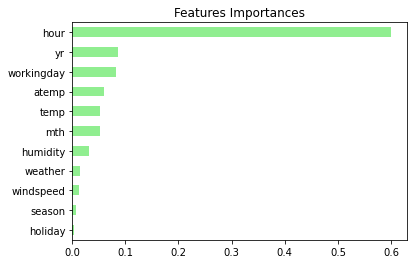

In [155]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Boosting  
Key take-away  
Boosting : sequencial training
- **AdaBoosting** (`Ada`ptive Boosting) : use prior model error to adjust the weight parameter for next model.  

In [157]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/ILPD.csv')
 .dropna()
 .assign(gender = lambda x : LabelBinarizer().fit_transform(x['gender']))
)

X = df.drop(['is_patient'], axis='columns')
y = df['is_patient']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

ada.fit(X_train, y_train)
# use [:, 1] for probability of predict y = 1 
y_pred_proba = ada.predict_proba(X_test)[:,1]

ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.67


- **GradientBoosting** : use prior model residual as target lable to train next model

In [165]:
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/bike_sharing_train.csv', parse_dates=['datetime'])
 .assign(hour = lambda x : x['datetime'].dt.hour)
 .assign(mth = lambda x : x['datetime'].dt.month)
 .assign(yr = lambda x : x['datetime'].dt.year)
 .drop(['casual', 'registered', 'datetime'], axis='columns')
)
y = df['count']
X = df.drop(['count'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [167]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 48.572


### **`Stocastic` Gradient Boosting** 
Use prior model residual as target lable to train next model, use subset of data to train and use subset of features to train. Solve overuse same features in Gradient boosting

In [168]:
from sklearn.model_selection import train_test_split

df = \
(pd
 .read_csv('../dataset/bike_sharing_train.csv', parse_dates=['datetime'])
 .assign(hour = lambda x : x['datetime'].dt.hour)
 .assign(mth = lambda x : x['datetime'].dt.month)
 .assign(yr = lambda x : x['datetime'].dt.year)
 .drop(['casual', 'registered', 'datetime'], axis='columns')
)
y = df['count']
X = df.drop(['count'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [171]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=0.9, # subset of train
            max_features=0.75, # subset of features
            n_estimators=200,                                
            random_state=2)
sgbr.fit(X_train, y_train)
y_pred = sgbr.predict(X_test)
mse_test = MSE(y_test, y_pred)
rmse_test = mse_test**(1/2)
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 46.751


# Tuning CART Hyper-parameter
With GridSearchCV  
Key take-away
- **parameters** : what model learn from data  
- **hyper-parameters** : what modeler define for model  


In [183]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

df = \
(pd
 .read_csv('../dataset/ILPD.csv')
 .dropna()
 .assign(gender = lambda x : LabelBinarizer().fit_transform(x['gender']))
)

X = df.drop(['is_patient'], axis='columns')
y = df['is_patient']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

In [184]:
# list of hyper parameter could be tune
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [185]:
# Define params_dt
params_dt = {'max_depth':[2,3,4],
             'min_samples_leaf':[0.12, 0.14, 0.16, 0.18]}

In [186]:
dt = DecisionTreeClassifier()

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]},
             scoring='roc_auc')

In [187]:
grid_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 0.16}

In [188]:
best_model = grid_dt.best_estimator_
y_pred_proba = grid_dt.predict_proba(X_test)[:,1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.681


Tuning RandomForest

In [204]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

df = \
(pd
 .read_csv('../dataset/bike_sharing_train.csv', parse_dates=['datetime'])
 .assign(hour = lambda x : x['datetime'].dt.hour)
 .assign(mth = lambda x : x['datetime'].dt.month)
 .assign(yr = lambda x : x['datetime'].dt.year)
 .drop(['casual', 'registered', 'datetime'], axis='columns')
)
y = df['count']
X = df.drop(['count'], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [209]:
rf = RandomForestRegressor()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators':[100, 350],
             'max_features':['log2', 'auto', 'sqrt'],
             'min_samples_leaf':[2,10]}

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=2,
                       verbose=2,
                       n_jobs=-1)

In [210]:
grid_rf.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [2, 10],
                         'n_estimators': [100, 350]},
             scoring='neg_mean_squared_error', verbose=2)

In [211]:
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 43.588
